Dataset extracted to path_to_extracted_folder


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Accuracy: 47.08%


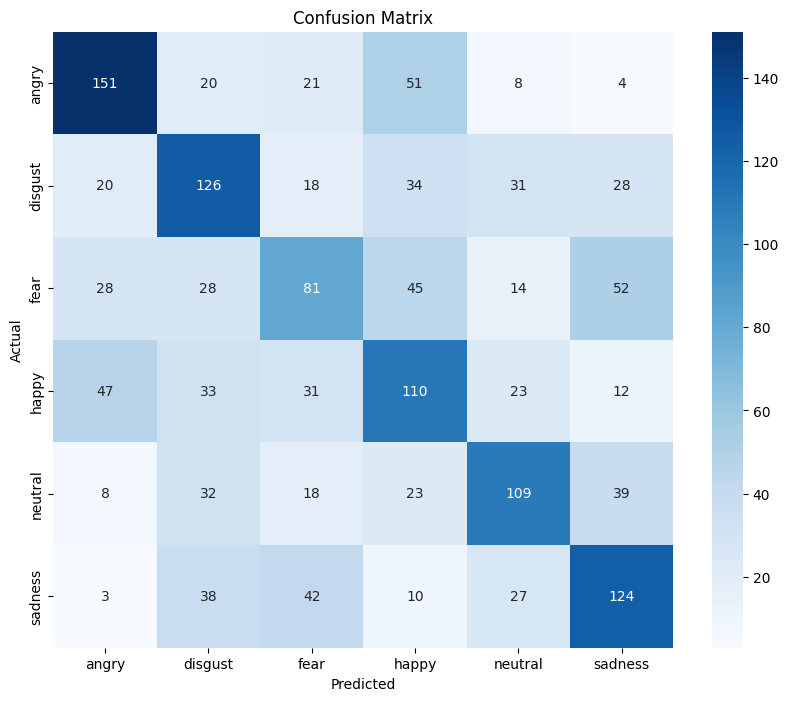

In [1]:
import os
import zipfile
import numpy as np
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Unzip the dataset
def unzip_dataset(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Dataset extracted to {extract_to}")

# Step 2: Feature extraction function
def extract_feature(file_path, mfcc=True, chroma=True, mel=True):
    with sf.SoundFile(file_path) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            stft = np.abs(librosa.stft(X))
            chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_features))

        if mel:
            mel_features = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_features))

        return result

# Step 3: Load dataset function
def load_dataset(dataset_dir):
    emotions = {
        'SAD': 'sadness',
        'ANG': 'angry',
        'DIS': 'disgust',
        'FEA': 'fear',
        'HAP': 'happy',
        'NEU': 'neutral'
    }

    features, labels = [], []

    for file in os.listdir(dataset_dir):
        if file.endswith(".wav"):
            try:
                emotion_code = file.split("_")[2]  # Adjust based on your filename structure
                emotion = emotions[emotion_code]
                file_path = os.path.join(dataset_dir, file)
                feature = extract_feature(file_path)
                features.append(feature)
                labels.append(emotion)
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")
                continue

    return np.array(features), np.array(labels)

# Step 4: Main program
if __name__ == "__main__":
    # Path to the zip file and extraction folder (update these paths)
    zip_path = "/content/Crema.zip"  # Replace with the actual path to your dataset zip file
    extract_to = "path_to_extracted_folder"  # Replace with where you want to extract the dataset

    # Unzip the dataset
    unzip_dataset(zip_path, extract_to)

    # Load data from extracted folder
    X, y = load_dataset(extract_to)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train MLP Classifier
    model = MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=256,
        max_iter=500,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Sample prediction function (optional)
def predict_emotion(file_path):
    feature = extract_feature(file_path)
    feature_scaled = scaler.transform([feature])
    prediction = model.predict(feature_scaled)[0]
    return prediction